<pre><div style="text-align:center">Shon Otmazgin    Sapir Rubin</div><div style="text-align:center">305394975        301659751</div></pre>

### Abstract
Credit card Supervised learning has been widely used to detect anomaly in credit card transaction records based on the assumption that the pattern of a fraud would depend on the past transaction. However, unsupervised learning does not ignore the fact that the fraudsters could change their approaches based on customers’ behaviors and patterns. In this study, three unsupervised methods were presented including GMM, K-means, and DB scan. The dataset used in this study is based on real-life data of credit card transaction. Due to the availability of the response, fraud labels, after training the models the performance of each model was evaluated. The performance of these three methods is discussed extensively in this paper.

### Dataset 
The dataset that is used for credit card fraud detection is derived from the following [URL](https://eur02.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdata.world%2Fraghu543%2Fcredit-card-fraud-data&amp;data=02%7C01%7CYael.Madar%40biu.ac.il%7Cb48189911f224aef8c2e08d79ff0c5e6%7C61234e145b874b67ac198feaa8ba8f12%7C0%7C0%7C637153728776732928&amp;sdata=tzNpfPA2qlY12Dp1Zli5FW5ugw0Q05OaTCay5mAvo4c%3D&amp;reserved=0)

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Due to confidentiality issues, there are not provided the original features and more background information about the data.
It contains only numerical input variables which are the result of a PCA transformation.

- Features V1, V2, ... V28 are the principal components obtained with PCA;
- The only features which have not been transformed with PCA are Time and Amount.
 - Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset.
 - The feature Amount is the transaction Amount.
- Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Problem Statement Task:

The Credit Card Fraud Detection Problem includes past credit card transactions. we need to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.
Let's realize that we are looking for a needle in a hay barn. 99% of the data are normal transactions. We could balance the data by oversampling or undersampling. But we want our models to be able to produce results in the real word not just in testing environment. This is why we should use the unbalanced data, in order to better simulate real world cases. If our model can identify even a fraction of fraud cases, it is adding value.

#### Load packages

In [1110]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib as mpl
import seaborn as sns

import itertools
from scipy import linalg

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn import mixture
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn import metrics
from scipy.stats import multivariate_normal


RANDOM_STATE = 42

### Data Exploration and visualization

In [3]:
df = pd.read_csv("../dataset/creditcard.csv")

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [25]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking to the Time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

#### Check missing data

In [26]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

#### Class Distribution

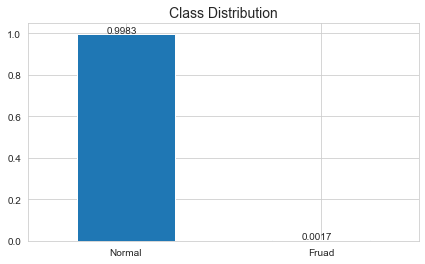

In [461]:
ax = df['Class'].value_counts(normalize=True).plot(kind='bar',  figsize=(7,4))
for i, v in enumerate(class_dist.values):
    ax.text(i - 0.1, v + 0.005, str(round(v, 4)))
ax.set_xticklabels(['Normal', 'Fruad'],rotation=0)
ax.set_title('Class Distribution', fontsize=14)

plt.show()

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.  
reminder - Unsupervised Learning is a process of training a machine learning model on a dataset in which target variable is unknown

#### Transactions Time and Amount Distributions

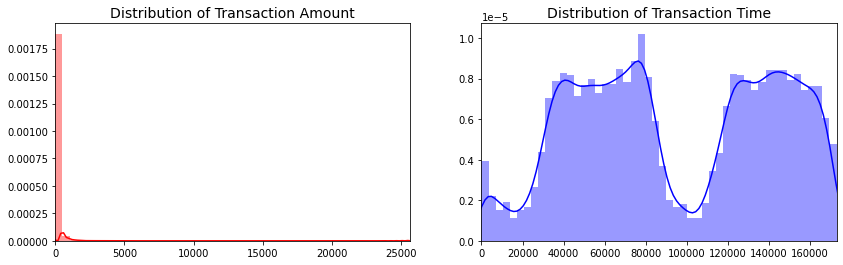

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

- Most transactions are small amounts, less than $100.
- Clearly, it looks like there are cycles in Time.

#### Transactions Time and Amount Distributions by Class

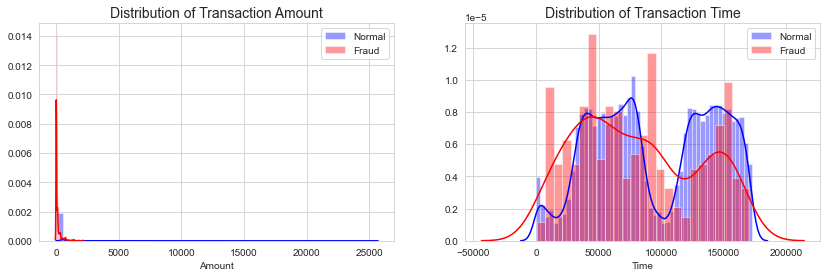

In [462]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

time_class_0 = df.loc[df['Class'] == 0]["Time"]
time_class_1 = df.loc[df['Class'] == 1]["Time"]
amount_class_0 = df.loc[df['Class'] == 0]["Amount"]
amount_class_1 = df.loc[df['Class'] == 1]["Amount"]

sns.distplot(amount_class_0, ax=ax[0], color='b' ,hist=True, label='Normal')
sns.distplot(amount_class_1, ax=ax[0], color='r' ,hist=True, label='Fraud')

sns.distplot(time_class_0, ax=ax[1], color='b' ,hist=True, label='Normal')
sns.distplot(time_class_1, ax=ax[1], color='r' ,hist=True, label='Fraud', bins=25)

ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[0].legend()
ax[1].legend()
plt.show()

- The 'Time' feature looks pretty similar across both types of transactions. You could argue that fraudulent transactions are more uniformly distributed, while normal transactions have a cyclical distribution. This could make it easier to detect a fraudulent transaction during at an 'off-peak' time.
- Most transactions are small amounts, less than $100. Fraudulent transactions have a maximum value far less than normal transactions, 2K vs 25k.


Now let's see if the transaction amount differs between the two types.

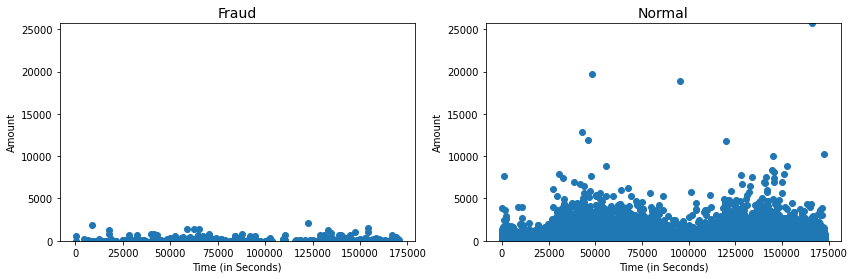

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

ax1.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1])
ax1.set_title('Fraud', fontsize=14)
ax1.set_ylim([min(amount_val), max(amount_val)])
ax1.set_ylabel('Amount')
ax1.set_xlabel('Time (in Seconds)')

ax2.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0])
ax2.set_title('Normal', fontsize=14)
ax2.set_ylim([min(amount_val), max(amount_val)])
ax2.set_ylabel('Amount')
ax2.set_xlabel('Time (in Seconds)')

plt.show()

Both types equally distributed over time. y-axis is signiffly different between fraud and normal transactions.

#### Outliers removal
Our main aim in this section is to remove "extreme outliers" from features. This will have a positive impact on the accuracy of our models.

#### Interquartile Range Method:
- **Interquartile Range (IQR)**: We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.
- **Boxplots**: Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme).

#### Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.


The Tradeoff: The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

#### Features distribution fit with Gaussian distribution

<Figure size 432x288 with 0 Axes>

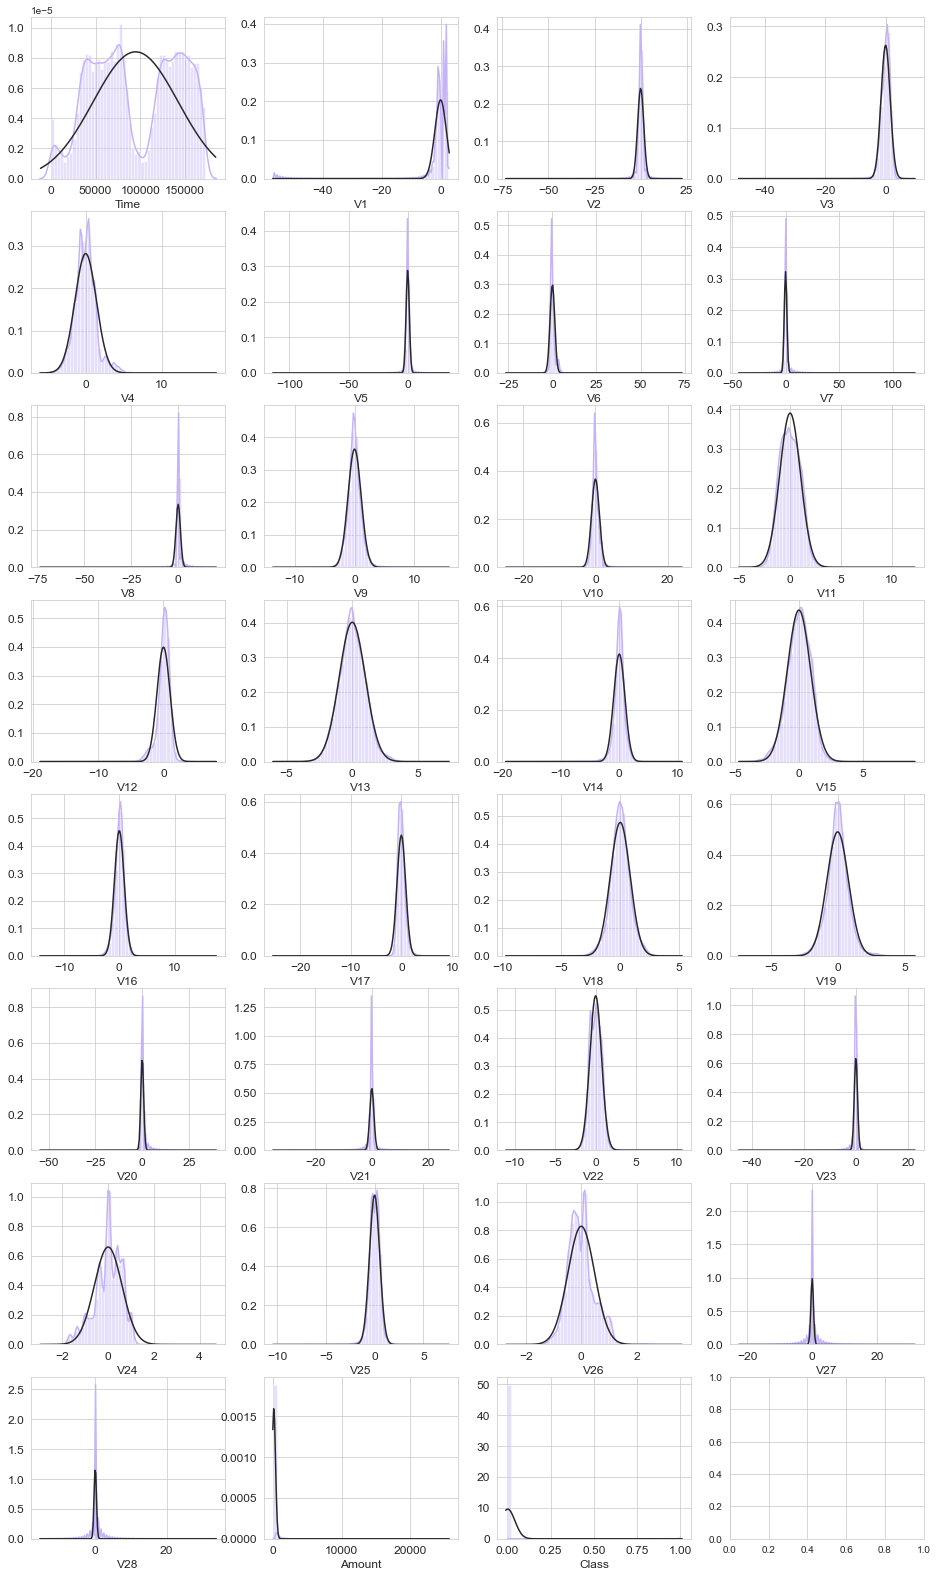

In [271]:
var = df.columns.values

i = 0

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.distplot(df[feature], fit=norm, color='#C5B3F9')
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

For some of the features we can observe a good selectivity in terms of distribution.

In general, with just few exceptions (Time and Amount), the features distribution for transactions is centered around 0, sometime with a long queue at one of the extremities.

#### Summary:
- **Visualize Distributions**: We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10.
- **Determining the threshold**: After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold).
- **Conditional Dropping**: Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed.
- **Boxplot Representation**: Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount.

<Figure size 432x288 with 0 Axes>

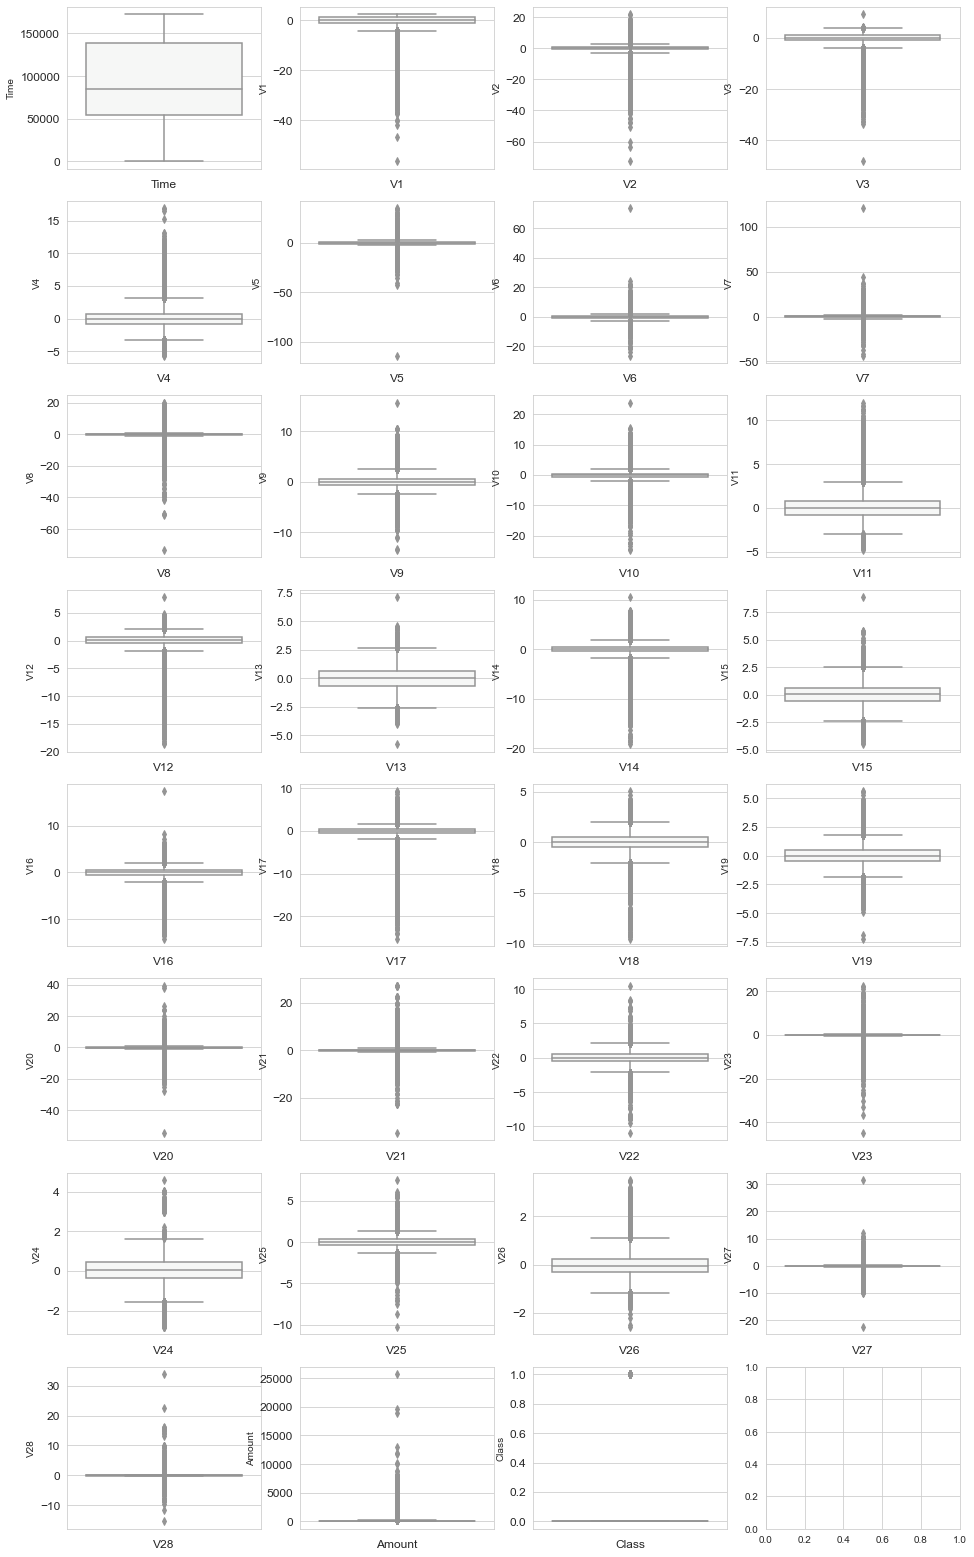

In [279]:
var = df.columns.values

i = 0

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    s = sns.boxplot(y=feature, hue="Class",data=df, palette="PRGn",showfliers=True)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [228]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
amount = df['Amount'].values
q25, q75 = np.percentile(amount, 25), np.percentile(amount, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
amount_iqr = q75 - q25
print('iqr: {}'.format(amount_iqr))

amount_cut_off = amount_iqr * 1.5
amount_lower, amount_upper = q25 - amount_cut_off, q75 + amount_cut_off
print('Cut Off: {}'.format(amount_cut_off))
print('amount Lower: {}'.format(amount_lower))
print('amount Upper: {}'.format(amount_upper))

outliers = [x for x in amount if x < amount_lower or x > amount_upper]
print('Feature amount Outliers Cases: {}'.format(len(outliers)))
# print('V10 outliers:{}'.format(outliers))

Quartile 25: 5.6 | Quartile 75: 77.16499999999999
iqr: 71.565
Cut Off: 107.3475
amount Lower: -101.7475
amount Upper: 184.5125
Feature amount Outliers Cases: 31904


The normal transaction have a larger median value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

#### Features correlation

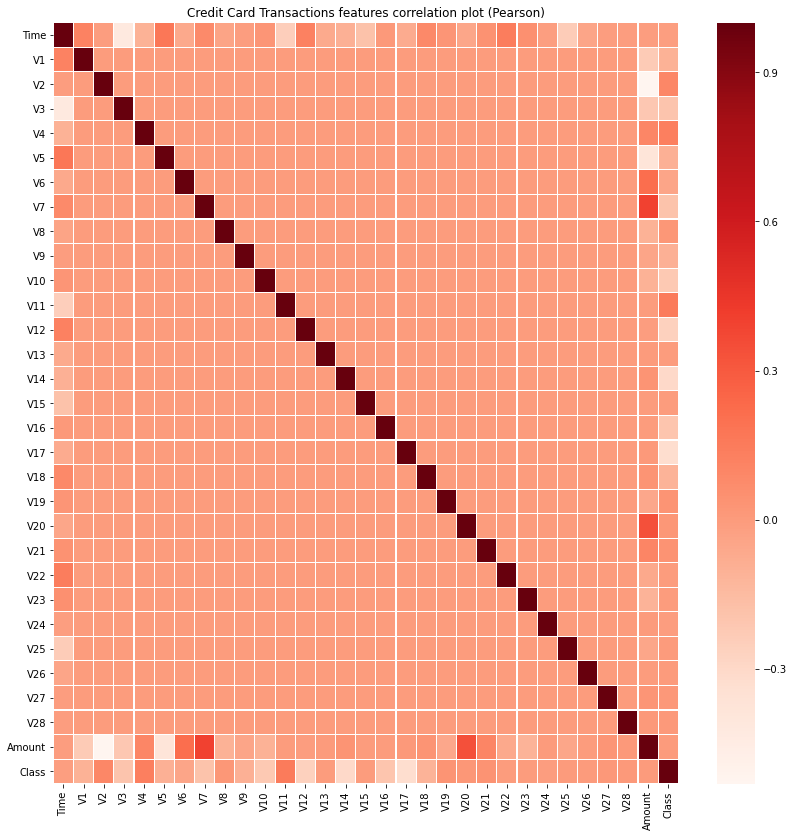

In [12]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).

We can confirm that the two couples of features are inverse correlated (the regression lines for Class = 0 have a negative slope while the regression lines for Class = 1 have a very small negative slope).

#### Scaling
In this phase of our paper, we will first scale the columns comprise of Time and Amount . Time and amount should be scaled as the other columns.

In [373]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


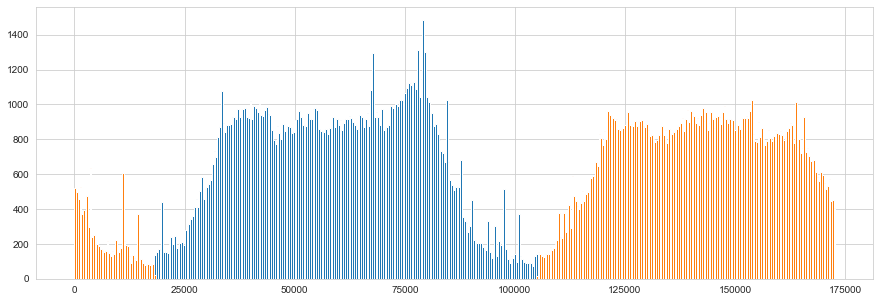

In [1161]:
Data = df.loc[(df['Time']>18103) & (df['Time']<105172),:]
Data_test = df.loc[(df['Time']<18104) | (df['Time']>105171),:] 

Data['Time'].hist(bins = 213, figsize = (15,5))
Data_test['Time'].hist(bins = 450, figsize = (15,5))
plt.show()

In [1162]:
Data = df

In [1163]:
Data = Data.reset_index()
Data = Data.drop('index', axis =1)

Data_test = Data_test.reset_index()
Data_test = Data_test.drop('index', axis = 1)

In [1164]:
#scale between (0,1)
Data_norm = StandardScaler().fit_transform(Data.iloc[:,:-1])
Data_norm = pd.DataFrame(Data_norm)
Data_norm['Class'] = Data['Class']
normal = Data_norm.loc[Data_norm['Class'] == 0, :]
fraud = Data_norm.loc[Data_norm['Class'] == 1, :]

In [1165]:
columns = [1,2,3,4,5,7,9,10,11,12,14,16,17,18,29]
columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

In [1166]:
Data = Data_norm.sample(frac = 1.0, random_state = RANDOM_STATE)
X = Data.loc[:,columns].reset_index(drop=True)
y = Data['Class'].reset_index(drop=True)
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [715]:
classifiers = {
    "ISOLATION FOREST":IsolationForest(n_estimators=155, max_samples=len(X), 
                                       contamination=.00194,random_state=42, verbose=0),
    "LOCAL OUTLIER FACTOR":LocalOutlierFactor(n_neighbors=200, algorithm='auto', leaf_size=230, 
                            metric='euclidean', p=1, metric_params=None, contamination=.0021),
    "ONE CLASS SVM":OneClassSVM(kernel='rbf', degree=3, gamma = 'auto', nu=0.00215, max_iter=-1)
}

C:\Users\sotmazgi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\sotmazgi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


ISOLATION FOREST number of errors: 48
col_0      0   1
Class           
0      28844  22
1         26  35
silhouette coefficient: 0.696
Adjusted Rand index   : 0.591
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28866
           1       0.61      0.57      0.59        61

    accuracy                           1.00     28927
   macro avg       0.81      0.79      0.80     28927
weighted avg       1.00      1.00      1.00     28927

roc_auc ISOLATION FOREST:  0.7865041747452616


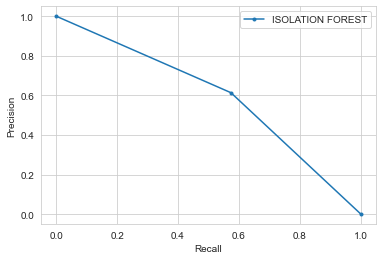

LOCAL OUTLIER FACTOR number of errors: 30
col_0      0   1
Class           
0      28851  15
1         15  46
silhouette coefficient: 0.699
Adjusted Rand index   : 0.753
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28866
           1       0.75      0.75      0.75        61

    accuracy                           1.00     28927
   macro avg       0.88      0.88      0.88     28927
weighted avg       1.00      1.00      1.00     28927

roc_auc LOCAL OUTLIER FACTOR:  0.876789359084884


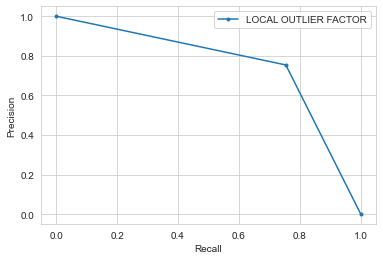

ONE CLASS SVM number of errors: 86
col_0      0   1
Class           
0      28823  43
1         43  18
silhouette coefficient: 0.623
Adjusted Rand index   : 0.293
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28866
           1       0.30      0.30      0.30        61

    accuracy                           1.00     28927
   macro avg       0.65      0.65      0.65     28927
weighted avg       1.00      1.00      1.00     28927

roc_auc ONE CLASS SVM:  0.6467961627100008


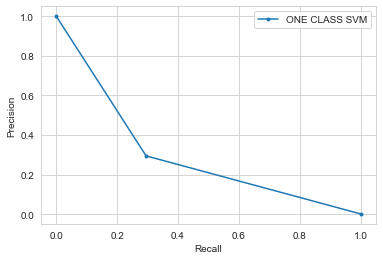

In [716]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "LOCAL OUTLIER FACTOR":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "ONE CLASS SVM":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    # Run Classification Metrics
    print("{} number of errors: {}".format(clf_name,n_errors))
    print(pd.crosstab(y, y_pred)) 
    print('silhouette coefficient:',round(metrics.silhouette_score(Data, y_pred, metric='euclidean'), 3))
    print('Adjusted Rand index   :',round(metrics.adjusted_rand_score(y, y_pred),3))
    print("3Classification Report :") 
    print(classification_report(y,y_pred))
    print(f'roc_auc {clf_name}: ', roc_auc_score(y, y_pred))
#     print(f'precision_recall_curve {clf_name}: ', precision_recall_curve(y, y_pred))
    precision, recall, _ = precision_recall_curve(y, y_pred)
    # plot the model precision-recall curve
    pyplot.plot(recall, precision, marker='.', label=clf_name)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

#### Statistical hypothesis testing

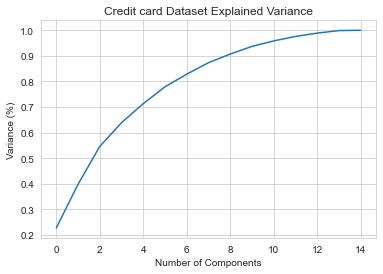

Wall time: 385 ms


In [957]:
%%time
from sklearn.decomposition import PCA

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Credit card Dataset Explained Variance')
plt.show()

In [986]:
%%time
from sklearn.decomposition import PCA

# PCA Implementation
X_reduced_pca_2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X)

Wall time: 135 ms


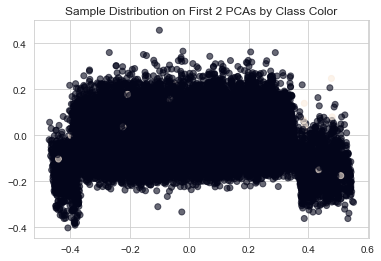

In [987]:
pca = PCA(2, random_state=RANDOM_STATE)
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)
x_pca.columns = ['pc1', 'pc2']

plt.figure()
plt.title('Sample Distribution on First 2 PCAs by Class Color')
plt.scatter(x_pca['pc1'], x_pca['pc2'], alpha = .6, c=y)
plt.show()

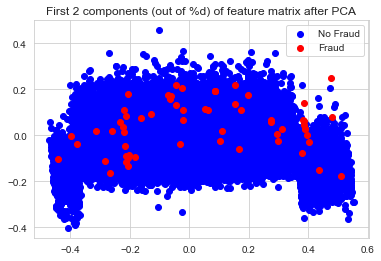

In [988]:
fig, ax1 = plt.subplots(ncols=1)

# PCA
ax1.scatter(X_reduced_pca_2[y[y == 0].index, 0], X_reduced_pca_2[y[y == 0].index, 1], cmap='coolwarm', label='No Fraud', color='blue')
ax1.scatter(X_reduced_pca_2[y[y == 1].index, 0], X_reduced_pca_2[y[y == 1].index, 1], cmap='coolwarm', label='Fraud', color='red')
ax1.set_title('First 2 components (out of %d) of feature matrix after PCA')

# plt.savefig(name + '.tif')
plt.legend()
plt.show()

In [721]:
from sklearn.mixture import GaussianMixture

In [722]:
%%time
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=RANDOM_STATE).fit(X) for n in n_components]

Wall time: 31.9 s


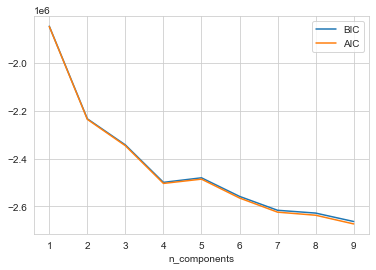

In [723]:
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [1167]:
%%time

lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

Wall time: 16min 6s


In [1168]:
print(f'Selected GMM: {best_gmm.covariance_type} model, {best_gmm.n_components} components')

Selected GMM: full model, 9 components


In [1169]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

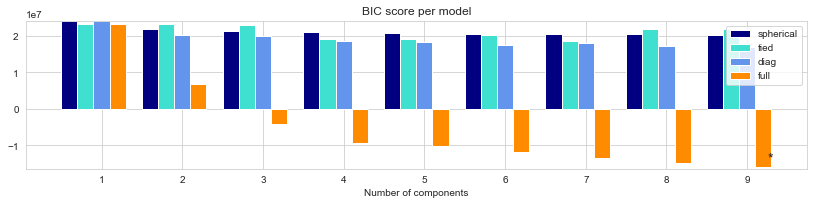

In [1170]:
# Plot the BIC scores
plt.figure(figsize=(14,6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

In [1171]:
X.shape

(284807, 30)

In [989]:
# X_reduced_pca_2 = pd.DataFrame(X_reduced_pca_2)
# X = X_reduced_pca_2

In [1064]:
#scale between (0,1)
# Data_norm = StandardScaler().fit_transform(X)
# X = pd.DataFrame(Data_norm)
# X
# Data_norm['Class'] = Data['Class']
# normal = Data_norm.loc[Data_norm['Class'] == 0, :]
# fraud = Data_norm.loc[Data_norm['Class'] == 1, :]

In [1032]:
# %%time
# p_x = []
# for i,sample in X.iterrows():
#     probs = clf.predict_proba(sample.values.reshape(1, -1))
#     p = 1
#     for p_i in probs[0]:
#         p = p * (1 - p_i)
#     p_x.append(1-p)

Wall time: 12 s


In [ ]:
1,10,15
[0.4 0.3 0.2]

In [1172]:
%%time
scores = []
for i,sample in X.iterrows():
    com = clf.predict(sample.values.reshape(1, -1))
    mu = clf.means_[com][0]
    sigma = clf.covariances_[com][0]
    p = multivariate_normal.pdf(x=sample.values.reshape(1, -1), mean=mu, cov=sigma)
    scores.append((i, p, y[i]))

Wall time: 2min 45s


In [1109]:
%%time
from scipy.stats import multivariate_normal
y_pred = clf.predict(X)
y_pred = pd.Series(y_pred)
pdf = pd.DataFrame(index=X.index.values, columns=['a'])
for i,(mu,sigma) in enumerate(zip(clf.means_,clf.covariances_)): 
    com = clf.predict(sample.values.reshape(1, -1))
    p = multivariate_normal.pdf(x=points, mean=mu, cov=sigma)
#     print(p)
#     break
    print(p)
    pdf.iloc[points.index.values]['a'] = p
    break
# pdf.iloc[7]['a'] = 3

[4.35948844e+00 5.55859911e+01 1.48729452e-05 ... 6.16284088e+02
 2.05453407e+02 6.97994190e+03]
Wall time: 208 ms


C:\Users\sotmazgi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [1108]:
pdf.iloc[7]

a    NaN
Name: 7, dtype: object

In [1033]:
%%time
count = 0
tp = 0
scores = []
for i,sample in X.iterrows():
    scores.append([i, 
                   clf.predict_proba(sample.values.reshape(1, -1)).argmax(), 
                   clf.predict_proba(sample.values.reshape(1, -1)).max(), 
                   p_x[i], y[i]])

Wall time: 20 s


In [1173]:
frauds = [s for s in scores if s[2] == 1]

In [1174]:
len(frauds)

492

In [1175]:
len([f for f in frauds if f[1] < 0.01])

435

In [1176]:
[f for f in frauds if f[1] < 0.01]

[(0, 1.735613779553445e-28, 1),
 (565, 5.4714790329606786e-18, 1),
 (3025, 7.045450132655225e-35, 1),
 (4178, 2.3720568907081864e-15, 1),
 (4640, 1.1255484769815643e-16, 1),
 (5100, 8.018217666323817e-28, 1),
 (5756, 1.947100540670069e-16, 1),
 (6054, 5.246371064963461e-15, 1),
 (6368, 4.8009379472076575e-120, 1),
 (7011, 3.734353475235818e-17, 1),
 (7846, 2.1120680520758903e-14, 1),
 (8090, 0.0018460646395174975, 1),
 (8379, 1.0920777538525462e-07, 1),
 (8456, 4.068594150417928e-23, 1),
 (9203, 5.014497623399992e-15, 1),
 (10279, 4.195602043941353e-18, 1),
 (10634, 1.9932431833909516e-31, 1),
 (11066, 8.230535873107206e-41, 1),
 (13509, 6.198077615773207e-21, 1),
 (16473, 6.086555352446382e-24, 1),
 (16564, 2.153249119445811e-31, 1),
 (16592, 5.151434409969746e-40, 1),
 (16839, 1.5191127985459243e-34, 1),
 (17345, 1.296987685578706e-15, 1),
 (18130, 7.967204806929576e-14, 1),
 (18544, 9.15489047951344e-24, 1),
 (18785, 4.835144533412737e-18, 1),
 (18861, 3.9160421867215746e-15, 1),
 (

In [1177]:
435/492

0.8841463414634146

In [762]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=1)
y_pred = kmeans.fit_predict(X_reduced_pca_2)

In [843]:
y_pred = kmeans.fit_predict(X_reduced_pca_2)
for i,sample in X_reduced_pca_2.iterrows():
    norm = np.linalg.norm(sample.values - kmeans.cluster_centers_)
    if norm>=0.24:
        y_pred[i] = 1

No handles with labels found to put in legend.


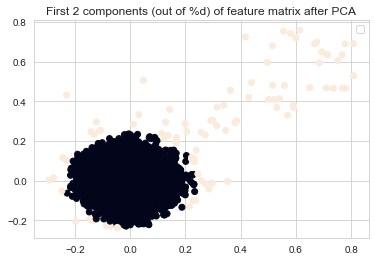

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28866
           1       0.53      0.80      0.64        61

    accuracy                           1.00     28927
   macro avg       0.76      0.90      0.82     28927
weighted avg       1.00      1.00      1.00     28927



In [844]:
fig, ax1 = plt.subplots(ncols=1)

# PCA
ax1.scatter(X_reduced_pca_2[0], X_reduced_pca_2[1],c=y_pred)
ax1.set_title('First 2 components (out of %d) of feature matrix after PCA')

# plt.savefig(name + '.tif')
plt.legend()
plt.show()
print(classification_report(y,y_pred))

In [426]:
%%time
count = 0
tp = 0
scores_2 = []
for i,s in enumerate(X.values):
    scores_2.append([i, kmeans.predict(s.reshape(1, -1))[0], kmeans.score(s.reshape(1, -1)), y[i]])

Wall time: 2min 39s


In [427]:
tp = [s for s in scores_2 if s[3] == 1]

In [440]:
([t for t in scores_2 if t[2] <= -500])

[[1632, 3, -3971.0583597987334, 0],
 [2234, 2, -512.738558892926, 0],
 [2464, 0, -637.8850344773595, 0],
 [2622, 3, -671.4025938628906, 0],
 [2682, 2, -549.5371594241926, 0],
 [2951, 2, -934.093796678636, 0],
 [2954, 2, -900.8564329225997, 0],
 [2957, 2, -889.0564030478308, 0],
 [2963, 2, -967.446733544791, 0],
 [3509, 2, -649.958038632228, 0],
 [5534, 2, -1260.8691864683606, 0],
 [5535, 2, -1250.621067361222, 0],
 [5652, 2, -961.6115618697384, 0],
 [5827, 2, -905.2118204038488, 0],
 [6108, 4, -502.15684620130634, 1],
 [6624, 2, -1242.776629404756, 0],
 [6717, 4, -510.4979477057971, 1],
 [6719, 5, -510.19493789690426, 1],
 [6812, 6, -1686.1115662543036, 0],
 [6882, 2, -510.2165350677282, 1],
 [6899, 2, -501.13767802287003, 1],
 [6903, 2, -503.9781284180527, 1],
 [7420, 4, -540.6675562390014, 0],
 [7743, 2, -1237.6669257850967, 0],
 [7744, 2, -909.423361752649, 0],
 [8296, 2, -1719.1034684245706, 1],
 [8335, 2, -1571.6548888363434, 1],
 [8610, 0, -5023.283259172904, 0],
 [8615, 2, -1692

In [439]:
([t for t in tp if t[2] <= -500])

[[6108, 4, -502.15684620130634, 1],
 [6717, 4, -510.4979477057971, 1],
 [6719, 5, -510.19493789690426, 1],
 [6882, 2, -510.2165350677282, 1],
 [6899, 2, -501.13767802287003, 1],
 [6903, 2, -503.9781284180527, 1],
 [8296, 2, -1719.1034684245706, 1],
 [8335, 2, -1571.6548888363434, 1],
 [8615, 2, -1692.6475062929562, 1],
 [8842, 2, -500.77175458370675, 1],
 [9035, 2, -1709.46854605081, 1],
 [9179, 2, -1545.1478603760893, 1],
 [9252, 2, -1669.7935987687504, 1],
 [9487, 2, -1694.488523455757, 1],
 [9509, 2, -1693.635256199235, 1],
 [10568, 2, -1695.399435719736, 1],
 [10630, 2, -1692.8694820841158, 1],
 [10690, 6, -2383.7654768416064, 1],
 [10801, 2, -1839.5304324985161, 1],
 [10891, 2, -1702.9904178083839, 1],
 [10897, 2, -1842.7552667913696, 1],
 [11343, 2, -1883.045327054875, 1],
 [11710, 2, -1903.7409696617817, 1],
 [11841, 2, -1927.1342978011148, 1],
 [11880, 2, -1953.2289100149706, 1],
 [12070, 2, -1982.0115743857923, 1],
 [12108, 2, -2013.4961056334175, 1],
 [12261, 2, -2047.6687483

In [285]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [286]:
wss = calculate_WSS(X_reduced_pca_2, 20)

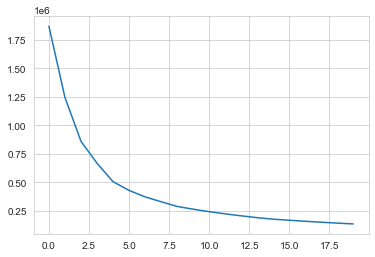

In [288]:
plt.plot(wss)

In [68]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
confusion_matrix = confusion_matrix(y, y_pred)
print('precision', precision)
print('recall', recall)
print(confusion_matrix)

precision 0.9941520467836257
recall 0.34552845528455284
[[2999    1]
 [ 322  170]]


In [69]:
from sklearn.metrics import roc_auc_score

print('Kmeans: ', roc_auc_score(y, y_pred))

Kmeans:  0.6725975609756097


### Methods
Clustering-Based Anomaly Detection
Clustering is one of the most popular concepts in the domain of unsupervised learning.

Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids.

K-means is a widely used clustering algorithm. It creates 'k' similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies.

In [57]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time

tic=time.time()
full_data=pd.read_csv("dataset/creditcard.csv")
full_data=full_data.sample(frac=1)#randomize the whole dataset
full_features=full_data.drop(["Time","Class"],axis=1)
full_labels=pd.DataFrame(full_data[["Class"]])
full_features_array=full_features.values
full_labels_array=full_labels.values
train_features,test_features,train_labels,test_labels=train_test_split(full_features_array,full_labels_array,train_size=0.90)
train_features=normalize(train_features)
test_features=normalize(test_features)
#k_means_classification --> k_means_clustering, confsion_matrix, reassigning
kmeans=KMeans(n_clusters=2,random_state=0,algorithm="elkan",max_iter=10000,n_jobs=-1)
kmeans.fit(train_features)
kmeans_predicted_train_labels=kmeans.predict(train_features)
#confusion matrix
# tn fp
# fn tp
print("tn --> true negatives")
print("fp --> false positives")
print("fn --> false negatives")
print("tp --> true positives")
tn,fp,fn,tp=confusion_matrix(train_labels,kmeans_predicted_train_labels).ravel()
reassignflag=False
if tn+tp<fn+fp:
	# clustering is opposite of original classification
	reassignflag=True
kmeans_predicted_test_labels=kmeans.predict(test_features)
if reassignflag:
	kmeans_predicted_test_labels=1-kmeans_predicted_test_labels
#calculating confusion matrix for kmeans
tn,fp,fn,tp=confusion_matrix(test_labels,kmeans_predicted_test_labels).ravel()
#scoring kmeans
kmeans_accuracy_score=accuracy_score(test_labels,kmeans_predicted_test_labels)
kmeans_precison_score=precision_score(test_labels,kmeans_predicted_test_labels)
kmeans_recall_score=recall_score(test_labels,kmeans_predicted_test_labels)
kmeans_f1_score=f1_score(test_labels,kmeans_predicted_test_labels)
#printing
print("")
print("K-Means")
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)
print("Scores")
print("Accuracy -->",kmeans_accuracy_score)
print("Precison -->",kmeans_precison_score)
print("Recall -->",kmeans_recall_score)
print("F1 -->",kmeans_f1_score)

#k_nearest_neighbours_classification
knn=KNeighborsClassifier(n_neighbors=5,algorithm="kd_tree",n_jobs=-1)
knn.fit(train_features,train_labels.ravel())
knn_predicted_test_labels=knn.predict(test_features)
#calculating confusion matrix for knn
tn,fp,fn,tp=confusion_matrix(test_labels,knn_predicted_test_labels).ravel()
#scoring knn
knn_accuracy_score=accuracy_score(test_labels,knn_predicted_test_labels)
knn_precison_score=precision_score(test_labels,knn_predicted_test_labels)
knn_recall_score=recall_score(test_labels,knn_predicted_test_labels)
knn_f1_score=f1_score(test_labels,knn_predicted_test_labels)
#printing
print("")
print("K-Nearest Neighbours")
print("Confusion Matrix")
print("tn =",tn,"fp =",fp)
print("fn =",fn,"tp =",tp)
print("Scores")
print("Accuracy -->",knn_accuracy_score)
print("Precison -->",knn_precison_score)
print("Recall -->",knn_recall_score)
print("F1 -->",knn_f1_score)

#time elapsed
toc=time.time()
elapsedtime=toc-tic
print("")
print("Time Taken : "+str(elapsedtime)+"seconds")

tn --> true negatives
fp --> false positives
fn --> false negatives
tp --> true positives

K-Means
Confusion Matrix
tn = 22548 fp = 5886
fn = 18 tp = 29
Scores
Accuracy --> 0.7927039078684035
Precison --> 0.004902789518174133
Recall --> 0.6170212765957447
F1 --> 0.009728279100972827

K-Nearest Neighbours
Confusion Matrix
tn = 28426 fp = 8
fn = 14 tp = 33
Scores
Accuracy --> 0.9992275552122467
Precison --> 0.8048780487804879
Recall --> 0.7021276595744681
F1 --> 0.7500000000000001

Time Taken : 25.955514192581177seconds


In [66]:
len(train_labels.ravel())

256326

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)